# Assignment-9


### Import necessary libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import base64
import copy
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


In [0]:
def splitTrainTest(data,percent):
    total=len(data)
    trainTotal=int(total*percent*0.01)
    testTotal=total-trainTotal
    return (data[0:trainTotal],data[trainTotal:total])

In [0]:
# Euclidean Distance
def distance(x,y,ax=1):
    return np.linalg.norm(x - y, axis=ax)
  
def MSE(xHat, x):
    return np.sum((xHat - x)**2) / len(x)

def MSE_prime(xHat, x):
    return xHat - x

### Layer Class
This class's object represent the layers in neural network. It stores the number of neurons in each layers, activations, activation function associated with each layer and their weight vector (initialize on gaussian distribute with mean =0 and std deviation=1).

In [0]:
class Layer:
    def __init__(self,nNodesCurrent, nNodesNext, activationF):
        self.nodesNo=nNodesCurrent
        self.activations = np.zeros([nNodesCurrent,1])
        self.activationF=activationF
        if nNodesNext==0:
            self.weights=None
        else:
            self.weights=np.random.normal(0, 1, size=(nNodesCurrent,nNodesNext))

### Neural Network Class
Class of neural network to perform autoencoding and decoding using mean square error between decoded input and actual input as cost function.
This class perform following tasks:
* Initialized the number of layers in neural network and create **Layer Class** object.
* Train the neural network on batches of inputs there by performing the forward and backward propogation using below helper methods.

#### Methods:
1. **Forward Propogation** : Perform the forward propogation, calculate and stores activations at each of the 
layer.
$$ z_1= w_1^TX $$
$$ a_1= f _1(z_1) $$
$$ z_2= w_2^Ta_1 $$
$$ \hat{y}= a_2= f_2(z_2) $$
2. **Calculate Error** : Here we calculate the mean square error of our neural network on the updated activations. This updation in activation take place after the updation of weights in gradient decent algorithm in backpropogation.
<br>
For multiclass classification we use the below cross entropy cost function:
$$ J =  \frac{1}{n} \sum\limits_{i}(\hat{x}-x)^2 $$
3. **Backward Propogation** : Here, we differentiate the cost function to minimize it, and find the optimal values of parameters ie weights at each of the layer.

<br>
also for cross entropy as a cost function and softmax as $f_2(z_2)$ , 
$$ \delta_3  =  \frac{\partial J}{\partial \hat{y} }  * \frac{\partial \hat{y}}{\partial z_2 } = (\hat{x} - x)*f^1 (z_2)  $$
<br>
$$ \therefore   \frac{\partial J}{\partial w_2 }= (\hat{x} - x) * a_1$$
<br><br>
Similarly to calculate parital derivative w.r.t weights of inner layers, we can use the chain rule
$$   \frac{\partial J}{\partial w_1 } = x^T *  \delta_3 *  w_2 *  f^1 (z_1)      $$

<hr>

**Some important activations functions and their derivatives used in our network**
**Softmax**
<br>
$$\sigma (z)_j = \frac{e^{z_j}}{\sum^K_{k=1} e^{z_j}}$$
**Sigmoid**
<br>
$$sigmoid(x) = \frac{1}{1+\epsilon ^ {-x}}$$
$$\frac{\partial sigmoid(x)}{\partial x} = sigmoid(x) * ( 1- sigmoid(x))$$

**Relu**
<br>
$$relu(x) = \max{(0,x)}$$
<br>
$$\frac{\partial relu(x)}{\partial x} = 1 \;\;\;\; if x>0  \\ 0 \;\;\; elsewhere$$

**tanh**
<br>
$$tanh(x) = \tanh{(x)}$$
<br>
$$\frac{\partial tanh(x)}{\partial x} = 1 - \tanh^2{(x)}$$

In [0]:
class NeuralNet:
    def __init__(self, totalLayers, noNodesList, activationFunctions):
        self.totalLayers=totalLayers
        self.noNodesList=noNodesList
        self.layers = []
        for i in range(totalLayers):
            currentLayerNodes=noNodesList[i]
            if i!=totalLayers-1:
                nextLayerNodes=noNodesList[i+1]
                ith_Layer=Layer(currentLayerNodes,nextLayerNodes,activationFunctions[i])
            else:
                ith_Layer=Layer(currentLayerNodes,0,activationFunctions[i])
            self.layers.append(ith_Layer)#append output layer as none

    def trainNetwork(self, data,outputLabels, batchSize, epochs, learningRate,printError=False):
        self.learningRate=learningRate
        self.batchSize=batchSize;
     
        for x in range(epochs):
            i=0  
            while i<len(data):
                self.error=0
                self.forwardPropo(data[i:i+batchSize])#input
                self.calculateError(data[i:i+batchSize])#output
                self.backwardPropo(data[i:i+batchSize])
                i+=batchSize
            self.error /= batchSize
            if printError:
                print("Epoch ",x,"->Error: ", self.error)
          
    def forwardPropo(self, inputs):
        self.layers[0].activations =inputs
        for i in range(self.totalLayers-1):
            temp=np.matmul(self.layers[i].activations,self.layers[i].weights)  
            if self.layers[i+1].activationF == "sigmoid":
                self.layers[i+1].activations = self.sigmoid(temp)
            elif self.layers[i+1].activationF == "softmax":
                self.layers[i+1].activations = self.softmax(temp)
            elif self.layers[i+1].activationF == "relu":
                self.layers[i+1].activations = self.relu(temp)
            elif self.layers[i+1].activationF == "tanh":
                self.layers[i+1].activations = self.tanh(temp)
            elif self.layers[i+1].activationF == "linear":
                self.layers[i+1].activations = self.linear(temp)
            else:
                self.layers[i+1].activations = temp
        
    def calculateError(self,labels):
          self.error +=MSE(self.layers[self.totalLayers-1].activations,labels)
    
    def backwardPropo(self, labels):
        targets = labels
        i = self.totalLayers-1
        y = self.layers[i].activations
        
        delta=(y-targets)
        if self.layers[i].activationF=="linear":
            prime= self.linear_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
        elif self.layers[i].activationF=="sigmoid":
            prime= self.sigmoid_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
        elif self.layers[i].activationF=="relu":
            prime= self.relu_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
        elif self.layers[i].activationF=="tanh":
            prime= self.tanh_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
        delta=np.multiply(prime,delta)
        
        deltaw = np.dot(self.layers[i-1].activations.T, delta)/self.batchSize
        new_weights = self.layers[i-1].weights - self.learningRate * deltaw
        for i in range(i-1, 0, -1):
            if self.layers[i].activationF=="sigmoid":
                prime= self.sigmoid_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
            elif self.layers[i].activationF=="relu":
                prime= self.relu_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
            elif self.layers[i].activationF=="tanh":
                prime= self.tanh_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
            elif self.layers[i].activationF=="linear":
                prime= self.linear_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
            
            delta=np.multiply(prime,delta.dot(self.layers[i].weights.T))
            deltaw = np.dot(self.layers[i-1].activations.T, delta)/self.batchSize

            self.layers[i].weights = new_weights
            new_weights = self.layers[i-1].weights - self.learningRate * deltaw
        self.layers[0].weights = new_weights
    
    
    def sigmoid(self, x):
        return np.divide(1, np.add(1, np.exp(np.negative(x))))
    
    def sigmoid_derivative(self,x):
        return (self.sigmoid(x)*(1-self.sigmoid(x)))
    
    def relu(self, x):
        return (x/700) * (x > 0)
    
    def relu_derivative(self,X):
        return 1. * (X > 0)
      
    def linear(self, x):
        return x/10
    
    def linear_derivative(self,X):
        return 1/10
    
    def softmax(self, x):
        x=np.nan_to_num(x)
        exp = np.exp(x)
        if isinstance(x[0], np.ndarray):
            return exp/np.sum(exp, axis=1, keepdims=True)
        else:
            return exp/np.sum(exp, keepdims=True)

    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self,x):
        return 1.0 - np.tanh(x) ** 2


## Question-1 problem of anomaly detection.

### Part-1 :  Dimenstionlity reduction using linear, non-linear activation function autoencoders , and deep autoencoders.

In [16]:
data=pd.read_csv("data.csv").values
X=data[:,0:29]
Y=data[:,29]
X = np.array(X, dtype=np.float64)
X=(X-X.mean(axis=0))/(X.std(axis=0))

numberofLayers=3
batchSize=64
epochs=50
noofneurons=[29,14,29]#14 neurons in bottleneck layer

activationFunctionsLinear=[None,"linear","linear"]
learningRatLinear=0.1


print("=================================================")
print("Linear Activation function")
print("=================================================")
nnLinear=NeuralNet(numberofLayers,noofneurons,activationFunctionsLinear)
nnLinear.trainNetwork(X,None,batchSize,epochs,learningRatLinear,printError=True)
nnLinear.batchSize = len(X)
nnLinear.forwardPropo(X)
encodedLinear = nnLinear.layers[int(nnLinear.totalLayers/2)].activations
decodedLinear = nnLinear.layers[nnLinear.totalLayers-1].activations
print("=================================================")
print("Encoded input shape: ",X.shape)
print("Encoded input shape: ",encodedLinear.shape)
print("Reduced dimension from %d to %d "%(X.shape[1],encodedLinear.shape[1]))
print("Decoded input shape: ",decodedLinear.shape)

data=pd.read_csv("data.csv").values
X=data[:,0:29]
Y=data[:,29]
X = np.array(X, dtype=np.float64)
X=(X-X.mean(axis=0))/(X.std(axis=0))
activationFunctionsNonLinear=[None,"relu","relu"]
learningRatNonLinear=0.1

print("=================================================")
print("Non Linear Activation function (relu)")
print("=================================================")
nnNonLinear=NeuralNet(numberofLayers,noofneurons,activationFunctionsNonLinear)
nnNonLinear.trainNetwork(X,None,batchSize,epochs,learningRatNonLinear,printError=True)
nnNonLinear.batchSize = len(X)
nnNonLinear.forwardPropo(X)
encodedNonLinear = nnNonLinear.layers[int(nnNonLinear.totalLayers/2)].activations
decodedNonLinear = nnNonLinear.layers[nnNonLinear.totalLayers-1].activations
print("=================================================")
print("Encoded input shape: ",X.shape)
print("Encoded input shape: ",encodedNonLinear.shape)
print("Reduced dimension from %d to %d "%(X.shape[1],encodedNonLinear.shape[1]))
print("Decoded input shape: ",decodedNonLinear.shape)


data=pd.read_csv("data.csv").values
X=data[:,0:29]
Y=data[:,29]
X = np.array(X, dtype=np.float64)
X=(X-X.mean(axis=0))/(X.std(axis=0))

numberofLayersDeep=7
noofneuronsDeep=[29,20,20,14,20,20,29]#14 neurons in bottleneck layer
activationFunctionsDeep=[None,"sigmoid","sigmoid","sigmoid","sigmoid","sigmoid","sigmoid"]
learningRatDeep=2

print("=================================================")
print("Deep autoencoders with non-linear activation functions")
print("=================================================")
deepNN=NeuralNet(numberofLayersDeep,noofneuronsDeep,activationFunctionsDeep)
deepNN.trainNetwork(X,None,batchSize,epochs,learningRatDeep,printError=True)
deepNN.batchSize = len(X)
deepNN.forwardPropo(X)
encodedDeep = deepNN.layers[int(deepNN.totalLayers/2)].activations
decodedDeep = deepNN.layers[deepNN.totalLayers-1].activations
print("=================================================")
print("Encoded input shape: ",X.shape)
print("Encoded input shape: ",encodedDeep.shape)
print("Reduced dimension from %d to %d "%(X.shape[1],encodedDeep.shape[1]))
print("Decoded input shape: ",decodedDeep.shape)


Linear Activation function
Epoch  0 ->Error:  0.4130894699876136
Epoch  1 ->Error:  0.33026589671523787
Epoch  2 ->Error:  0.2674183046869788
Epoch  3 ->Error:  0.2193465287109993
Epoch  4 ->Error:  0.18291309464586875
Epoch  5 ->Error:  0.15609753841054042
Epoch  6 ->Error:  0.13607156750728278
Epoch  7 ->Error:  0.12083512612271438
Epoch  8 ->Error:  0.1095950085848179
Epoch  9 ->Error:  0.10169646128071377
Epoch  10 ->Error:  0.09629585058701402
Epoch  11 ->Error:  0.09257483012559814
Epoch  12 ->Error:  0.08989891951953735
Epoch  13 ->Error:  0.08785129718388429
Epoch  14 ->Error:  0.0861902113591407
Epoch  15 ->Error:  0.08478358142338388
Epoch  16 ->Error:  0.08355646036589322
Epoch  17 ->Error:  0.0824617081656657
Epoch  18 ->Error:  0.08146768592903061
Epoch  19 ->Error:  0.08055336696733578
Epoch  20 ->Error:  0.07970535073986686
Epoch  21 ->Error:  0.07891531804287939
Epoch  22 ->Error:  0.07817799280088185
Epoch  23 ->Error:  0.07748974157025212
Epoch  24 ->Error:  0.0768477

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in exp


Epoch  26 ->Error:  0.490404284311802
Epoch  27 ->Error:  0.49143174623326646
Epoch  28 ->Error:  0.48984856442249985
Epoch  29 ->Error:  0.5290050167111772
Epoch  30 ->Error:  0.5094513404544943
Epoch  31 ->Error:  0.4898302853266394
Epoch  32 ->Error:  0.4894131647760019
Epoch  33 ->Error:  0.49150709280485383
Epoch  34 ->Error:  0.4894385597046871
Epoch  35 ->Error:  0.48950020611555295
Epoch  36 ->Error:  0.4892208289003771
Epoch  37 ->Error:  0.4889839688250807
Epoch  38 ->Error:  0.4893009523250927
Epoch  39 ->Error:  0.4890198509893548
Epoch  40 ->Error:  0.4889402689704595
Epoch  41 ->Error:  0.5190674979252156
Epoch  42 ->Error:  0.4906036415475251
Epoch  43 ->Error:  0.4888684801208714
Epoch  44 ->Error:  0.489001530256329
Epoch  45 ->Error:  0.48928084199734273
Epoch  46 ->Error:  0.4969679719065045
Epoch  47 ->Error:  0.4889821794174539
Epoch  48 ->Error:  0.48912262934870354
Epoch  49 ->Error:  0.4892897179861203
Encoded input shape:  (24998, 29)
Encoded input shape:  (249

In [0]:
def KMeans(k,noofneurons=[29,14,29],activationFunctions=[None,"linear","linear"],learningRat=0.1,forgraph=False):
    data=pd.read_csv("data.csv").values
    X=data[:,0:29]
    Y=data[:,29]
    X = np.array(X, dtype=np.float64)
    X=(X-X.mean(axis=0))/(X.std(axis=0))
    
    numberofLayers=len(noofneurons)
    batchSize=64
    epochs=50
    
    
    nn=NeuralNet(numberofLayers,noofneurons,activationFunctions)
    nn.trainNetwork(X,None,batchSize,epochs,learningRat)
    nn.batchSize = len(X)
    nn.forwardPropo(X)
    
    
    X=nn.layers[nn.totalLayers-2].activations
    X=(X-X.mean(axis=0))/(X.std(axis=0))
    dimensions=X.shape[1]
    
    count=0
    cc=[]
    for i in range(k):
        centroid=np.random.random_sample(dimensions)
        cc.append(centroid)
    newCentroids=np.array(cc)
    oldCentroids=np.zeros(newCentroids.shape)
    clusterMap=np.zeros(len(X))
    error=distance(newCentroids,oldCentroids,None)

    count=0
    clusterPoints={}
    while error>0.01:

        for i in range(len(X)):
            dist=distance(X[i],newCentroids)
            clusterMap[i]=np.argmin(dist)
        oldCentroids=copy.deepcopy(newCentroids)
    # Finding the new centroids by taking the average value
        for i in range(k):
            points=[]
            indexes=[]
            for j in range(len(X)):
                if clusterMap[j]==i:
                    points.append(X[j])
                    indexes.append(j)
                    
            if len(points)>0:
                newCentroids[i]=np.mean(points,axis=0)
            clusterPoints[i]=indexes
        error=distance(newCentroids,oldCentroids,None)
        count+=1
    methodPurity=0
    graphLabels=[]
    graphClusters=[]
    for key in clusterPoints.keys():
        indexes=clusterPoints[key]
        labels=np.array([ Y[index] for index in indexes])
        uniq,counts=np.unique(labels,return_counts=True)
        countIndex=np.argmax(counts)
        methodPurity+=counts[countIndex]
        if forgraph:
          graphLabels.append(uniq[countIndex]+" : "+str(counts[countIndex]/len(indexes)))
          graphClusters.append(len(indexes))
          continue
        print("========================================")
        print("Cluster: ",key+1)
        print("========================================")
        print("%10s || %2s "%("class","count"))
        print("________________________")
        for a,b in zip(uniq,counts):
          print("%10s || %2s "%(a,b))
        print()
        print("Max class '%s' with purity %s . "%(uniq[countIndex],counts[countIndex]/len(indexes)))
        print("========================================")
    if forgraph:
      return (methodPurity/len(X),graphLabels,graphClusters)
 
    print("Method clustering Purity= ",methodPurity/len(X))

### Part-2 : K-means Clustering on  dimensionality reduced inputs.

#### Part-2-a : K-means with linear activation functions in autoencoder

In [18]:
KMeans(5,noofneurons=[29,14,29],activationFunctions=[None,"linear","linear"])

Cluster:  1
     class || count 
________________________
       dos || 6800 
    normal || 24 
     probe || 20 

Max class 'dos' with purity 0.9935710111046172 . 
Cluster:  2
     class || count 
________________________
       dos || 114 
    normal || 1814 
     probe || 329 
       r2l ||  9 
       u2r ||  2 

Max class 'normal' with purity 0.7998236331569665 . 
Cluster:  3
     class || count 
________________________
       dos || 1364 
    normal || 518 
     probe || 1058 
       r2l || 10 

Max class 'dos' with purity 0.4623728813559322 . 
Cluster:  4
     class || count 
________________________
       dos || 407 
    normal || 10809 
     probe || 87 
       r2l || 114 
       u2r ||  8 

Max class 'normal' with purity 0.9460831509846828 . 
Cluster:  5
     class || count 
________________________
       dos || 429 
    normal || 199 
     probe || 819 
       r2l || 64 

Max class 'probe' with purity 0.5420251489080079 . 
Method clustering Purity=  0.8643091447315785


#### Part-2-b : K-means with non linear activation functions (ReLu) in autoencoder

In [19]:
KMeans(5,noofneurons=[29,14,29],activationFunctions=[None,"relu","relu"])

Cluster:  1
     class || count 
________________________
       dos || 795 
    normal || 11834 
     probe || 179 
       r2l || 169 
       u2r ||  9 

Max class 'normal' with purity 0.9112890805482827 . 
Cluster:  2
     class || count 
________________________
       dos || 1413 
    normal || 1078 
     probe || 377 
       r2l ||  2 

Max class 'dos' with purity 0.49233449477351915 . 
Cluster:  3
     class || count 
________________________
       dos ||  8 
    normal || 251 
     probe || 826 
       r2l || 16 
       u2r ||  1 

Max class 'probe' with purity 0.7495462794918331 . 
Cluster:  4
     class || count 
________________________
    normal || 166 
     probe || 870 
       r2l || 10 

Max class 'probe' with purity 0.8317399617590823 . 
Cluster:  5
     class || count 
________________________
       dos || 6898 
    normal || 35 
     probe || 61 

Max class 'dos' with purity 0.9862739490992279 . 
Method clustering Purity=  0.8737098967917434


#### Part-2-c : K-means with deep autoencoder

In [20]:
KMeans(k=5,noofneurons=[29,20,20,14,20,20,29],activationFunctions=[None,"sigmoid","sigmoid","sigmoid","sigmoid","sigmoid","sigmoid"],learningRat=2)

Cluster:  1
     class || count 
________________________
       dos || 1373 
    normal || 585 
     probe || 1075 
       r2l || 10 

Max class 'dos' with purity 0.45119947420308903 . 
Cluster:  2
     class || count 
________________________
       dos || 615 
    normal || 1948 
     probe || 856 
       r2l || 175 
       u2r ||  3 

Max class 'normal' with purity 0.5415624131220461 . 
Cluster:  3
     class || count 
________________________
       dos || 136 
    normal || 8472 
     probe ||  4 
       r2l ||  8 

Max class 'normal' with purity 0.982830626450116 . 
Cluster:  4
     class || count 
________________________
       dos || 6804 
    normal || 29 
     probe ||  5 
       r2l ||  1 

Max class 'dos' with purity 0.9948822927328557 . 
Cluster:  5
     class || count 
________________________
       dos || 186 
    normal || 2330 
     probe || 373 
       r2l ||  3 
       u2r ||  7 

Max class 'normal' with purity 0.8037254225595033 . 
Method clustering Purity=  0.83

In [0]:
def gMM(k,noofneurons=[29,14,29],activationFunctions=[None,"linear","linear"],learningRat=0.1,forgraph=False):
    data=pd.read_csv("data.csv").values
    X=data[:,0:29]
    Y=data[:,29]
    
    X = np.array(X, dtype=np.float64)
    X=(X-X.mean(axis=0))/(X.std(axis=0))
    
    numberofLayers=len(noofneurons)
    batchSize=64
    epochs=50
    
    nn=NeuralNet(numberofLayers,noofneurons,activationFunctions)
    nn.trainNetwork(X,None,batchSize,epochs,learningRat)
    nn.batchSize = len(X)
    nn.forwardPropo(X)
    
    dimensions=14
    X=nn.layers[nn.totalLayers-2].activations
#     Y=data[2]
    gmm = GaussianMixture(n_components = k)
    gmm.fit(X)
    labels=gmm.predict(X) 
    labelsDict={}
    for index,label in enumerate(labels):
        labelsDict.setdefault(label,[]).append(index)
    methodPurity=0
    graphLabels=[]
    graphClusters=[]
    for key in labelsDict.keys():
        indexes=labelsDict[key]
        labelss=np.array([Y[index] for index in indexes])
        uniq,counts=np.unique(labelss,return_counts=True)
        countIndex=np.argmax(counts)
        methodPurity+=counts[countIndex]
        if forgraph:
          graphLabels.append(uniq[countIndex]+" : "+str(counts[countIndex]/len(indexes)))
          graphClusters.append(len(indexes))
          continue
        print("========================================")
        print("Cluster: ",key+1)
        print("========================================")
        print("%10s || %2s "%("class","count"))
        print("________________________")
        for a,b in zip(uniq,counts):
          print("%10s || %2s "%(a,b))
        print()
        print("Max class '%s' with purity %s . "%(uniq[countIndex],counts[countIndex]/len(indexes)))       
        print("========================================")
    if forgraph:
      return (methodPurity/len(X),graphLabels,graphClusters)
    print("Method clustering Purity= ",methodPurity/len(X))

### Part-3 :Gaussian Mixture Model  on  dimensionality reduced inputs.

#### Part-3-a :GMM with linear activation functions in autoencoder

In [27]:
gMM(5,noofneurons=[29,14,29],activationFunctions=[None,"linear","linear"])

Cluster:  2
     class || count 
________________________
       dos || 766 
    normal || 5615 
     probe || 1112 
       r2l || 140 
       u2r ||  2 

Max class 'normal' with purity 0.7354289456450557 . 
Cluster:  3
     class || count 
________________________
       dos || 1362 
    normal || 384 
     probe || 778 

Max class 'dos' with purity 0.5396196513470681 . 
Cluster:  5
     class || count 
________________________
       dos || 578 
    normal || 6432 
     probe || 86 
       r2l || 22 
       u2r ||  3 

Max class 'normal' with purity 0.9032439264148294 . 
Cluster:  1
     class || count 
________________________
       dos || 6254 

Max class 'dos' with purity 1.0 . 
Cluster:  4
     class || count 
________________________
       dos || 154 
    normal || 933 
     probe || 337 
       r2l || 35 
       u2r ||  5 

Max class 'normal' with purity 0.6372950819672131 . 
Method clustering Purity=  0.8239059124729978


#### Part-3-b : GMM with non linear activation functions (ReLu) in autoencoder

In [29]:
gMM(5,noofneurons=[29,14,29],activationFunctions=[None,"relu","relu"])

Cluster:  1
     class || count 
________________________
       dos || 671 
    normal || 10196 
     probe || 12 
       r2l ||  6 
       u2r ||  1 

Max class 'normal' with purity 0.9366158368546758 . 
Cluster:  2
     class || count 
________________________
       dos || 1543 
    normal || 1300 
     probe || 1143 
       r2l ||  8 
       u2r ||  1 

Max class 'dos' with purity 0.3862327909887359 . 
Cluster:  5
     class || count 
________________________
       dos || 6760 
    normal ||  8 
     probe ||  2 

Max class 'dos' with purity 0.9985228951255539 . 
Cluster:  3
     class || count 
________________________
       dos || 44 
    normal || 1258 
     probe || 885 
       r2l || 93 
       u2r ||  2 

Max class 'normal' with purity 0.551270815074496 . 
Cluster:  4
     class || count 
________________________
       dos || 96 
    normal || 602 
     probe || 271 
       r2l || 90 
       u2r ||  6 

Max class 'normal' with purity 0.5652582159624413 . 
Method clusterin

#### Part-3-c : GMM with deep autoencoders

In [30]:
gMM(k=5,noofneurons=[29,20,20,14,20,20,29],activationFunctions=[None,"sigmoid","sigmoid","sigmoid","sigmoid","sigmoid","sigmoid"],learningRat=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in exp


Cluster:  4
     class || count 
________________________
       dos || 185 
    normal || 7617 

Max class 'normal' with purity 0.9762881312483979 . 
Cluster:  5
     class || count 
________________________
       dos || 1323 
     probe || 412 

Max class 'dos' with purity 0.7625360230547551 . 
Cluster:  3
     class || count 
________________________
       dos || 474 
    normal || 3282 
     probe || 878 
       r2l || 114 
       u2r ||  7 

Max class 'normal' with purity 0.6902208201892744 . 
Cluster:  1
     class || count 
________________________
       dos || 6184 

Max class 'dos' with purity 1.0 . 
Cluster:  2
     class || count 
________________________
       dos || 948 
    normal || 2465 
     probe || 1023 
       r2l || 83 
       u2r ||  3 

Max class 'normal' with purity 0.5451127819548872 . 
Method clustering Purity=  0.8349067925434035


In [0]:
def heirarchical(k,noofneurons=[29,14,29],activationFunctions=[None,"linear","linear"],learningRat=0.1,forgraph=False):
    data=pd.read_csv("data.csv").values
    X=data[:,0:29]
    Y=data[:,29]
    
    X = np.array(X, dtype=np.float64)
    X=(X-X.mean(axis=0))/(X.std(axis=0))
    
    numberofLayers=len(noofneurons)
    batchSize=64
    epochs=50
    
    nn=NeuralNet(numberofLayers,noofneurons,activationFunctions)
    nn.trainNetwork(X,None,batchSize,epochs,learningRat)
    nn.batchSize = len(X)
    nn.forwardPropo(X)
    
    dimensions=14
    X=nn.layers[nn.totalLayers-2].activations
    
    aglo = AgglomerativeClustering(linkage="single", n_clusters=k)
    aglo.fit(X)
    labels=aglo.labels_
    labelsDict={}
    for index,label in enumerate(labels):
        labelsDict.setdefault(label,[]).append(index)
    methodPurity=0
    graphLabels=[]
    graphClusters=[]
    for key in labelsDict.keys():
        indexes=labelsDict[key]
        labelss=np.array([Y[index] for index in indexes])
        uniq,counts=np.unique(labelss,return_counts=True)
        countIndex=np.argmax(counts)
        methodPurity+=counts[countIndex]
        if forgraph:
          graphLabels.append(uniq[countIndex]+" : "+str(counts[countIndex]/len(indexes)))
          graphClusters.append(len(indexes))
          continue
        print("========================================")
        print("Cluster: ",key+1)
        print("========================================")
        print("%10s || %2s "%("class","count"))
        print("________________________")
        for a,b in zip(uniq,counts):
          print("%10s || %2s "%(a,b))
        print()
        print("Max class '%s' with purity %s . "%(uniq[countIndex],counts[countIndex]/len(indexes)))
        print("========================================")
    if forgraph:
      return (methodPurity/len(X),graphLabels,graphClusters)
    print("Method clustering Purity= ",methodPurity/len(X))

### Part-4 : Heirarchical Clustering on dimensionality reduced inputs.

#### Part-4-a :Heirarchical Clustering with linear activation functions in autoencoder

In [32]:
heirarchical(5,noofneurons=[29,14,29],activationFunctions=[None,"linear","linear"])

Cluster:  1
     class || count 
________________________
       dos || 9114 
    normal || 13360 
     probe || 2312 
       r2l || 193 
       u2r || 10 

Max class 'normal' with purity 0.5346352395053824 . 
Cluster:  3
     class || count 
________________________
    normal ||  2 
       r2l ||  4 

Max class 'r2l' with purity 0.6666666666666666 . 
Cluster:  5
     class || count 
________________________
    normal ||  1 

Max class 'normal' with purity 1.0 . 
Cluster:  4
     class || count 
________________________
    normal ||  1 

Max class 'normal' with purity 1.0 . 
Cluster:  2
     class || count 
________________________
     probe ||  1 

Max class 'probe' with purity 1.0 . 
Method clustering Purity=  0.5347227778222258


#### Part-4-b :Heirarchical Clustering with non linear activation functions (ReLu) in autoencoder

In [33]:
heirarchical(5,noofneurons=[29,14,29],activationFunctions=[None,"relu","relu"])

Cluster:  1
     class || count 
________________________
       dos || 9114 
    normal || 13359 
     probe || 2313 
       r2l || 193 
       u2r || 10 

Max class 'normal' with purity 0.534595221897635 . 
Cluster:  2
     class || count 
________________________
    normal ||  2 
       r2l ||  4 

Max class 'r2l' with purity 0.6666666666666666 . 
Cluster:  3
     class || count 
________________________
    normal ||  1 

Max class 'normal' with purity 1.0 . 
Cluster:  5
     class || count 
________________________
    normal ||  1 

Max class 'normal' with purity 1.0 . 
Cluster:  4
     class || count 
________________________
    normal ||  1 

Max class 'normal' with purity 1.0 . 
Method clustering Purity=  0.5346827746219698


#### Part-4-c :Heirarchical Clustering with deep autoencoders.

In [34]:
heirarchical(k=5,noofneurons=[29,20,20,14,20,20,29],activationFunctions=[None,"sigmoid","sigmoid","sigmoid","sigmoid","sigmoid","sigmoid"],learningRat=2)

Cluster:  1
     class || count 
________________________
       dos || 9114 
    normal || 13349 
     probe || 2312 
       r2l || 187 
       u2r || 10 

Max class 'normal' with purity 0.5345587057504405 . 
Cluster:  3
     class || count 
________________________
    normal || 11 
     probe ||  1 
       r2l || 10 

Max class 'normal' with purity 0.5 . 
Cluster:  5
     class || count 
________________________
    normal ||  1 

Max class 'normal' with purity 1.0 . 
Cluster:  2
     class || count 
________________________
    normal ||  2 

Max class 'normal' with purity 1.0 . 
Cluster:  4
     class || count 
________________________
    normal ||  1 

Max class 'normal' with purity 1.0 . 
Method clustering Purity=  0.5346027682214577


### Part-5 : Pie chart comparing purity of different clustering methods


In [0]:
def pieChart(noofneurons=[29,14,29],activationFunctions=[None,"linear","linear"],learningRat=0.1):
  fig, ax = plt.subplots()
  km=KMeans(5,forgraph=True,noofneurons=noofneurons,activationFunctions=activationFunctions,learningRat=learningRat)
  gm=gMM(5,forgraph=True,noofneurons=noofneurons,activationFunctions=activationFunctions,learningRat=learningRat)
  heir=heirarchical(5,forgraph=True,noofneurons=noofneurons,activationFunctions=activationFunctions,learningRat=learningRat)
  

  size = 0.6
  labels1=["K-Means Clustering (Purity = "+str(km[0])+")","GMM Clustring (Purity = "+str(gm[0])+")","Heirarchical clustering (Purity = "+str(heir[0])+")"]
  vals = np.array([km[2], gm[2], heir[2]])

  cmap = plt.get_cmap("tab20c")
  outer_colors = cmap(np.arange(3)*4)
  # inner_colors = cmap(np.array([1,2,3,4,5,8,9,10,11,12,15,16,17,18,19]))
  labels2=km[1]+gm[1]+heir[1]
  # print(vals)
  # print(labels1)
  # print(labels2)

  ax.pie(vals.sum(axis=1), radius=2, colors=outer_colors,wedgeprops=dict(width=size, edgecolor='w'),labels=labels1)

  # plt.figure(figsize=(30,30))
  print("Pie chart comparing purity of KNN,GMM, and herirchical along with resp. clusters purity")
  ax.pie(vals.flatten(),rotatelabels=True,labeldistance=0.7,radius=2-size,wedgeprops=dict(width=size, edgecolor='w'),labels=labels2)
  plt.show()

#### Linear activation functions in autoencoders

Pie chart comparing purity of KNN,GMM, and herirchical along with resp. clusters purity


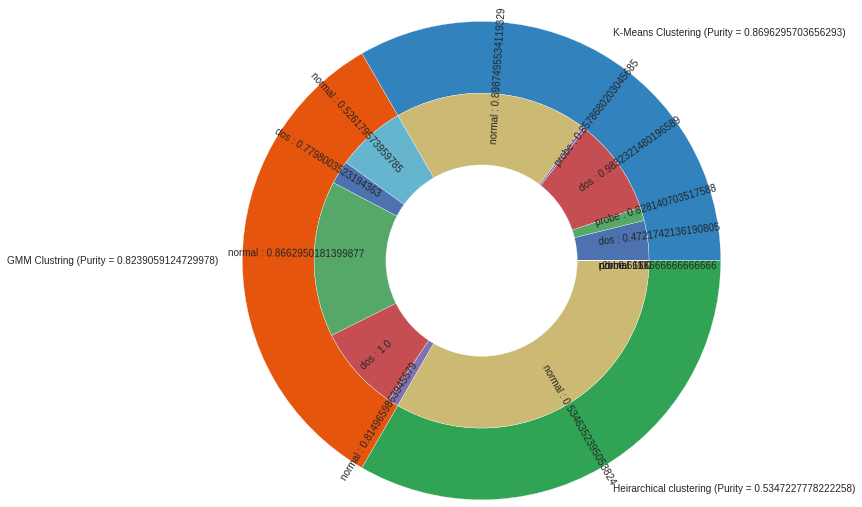

In [37]:
pieChart()

#### Non linear activation functions(ReLu) in autoencoders

Pie chart comparing purity of KNN,GMM, and herirchical along with resp. clusters purity


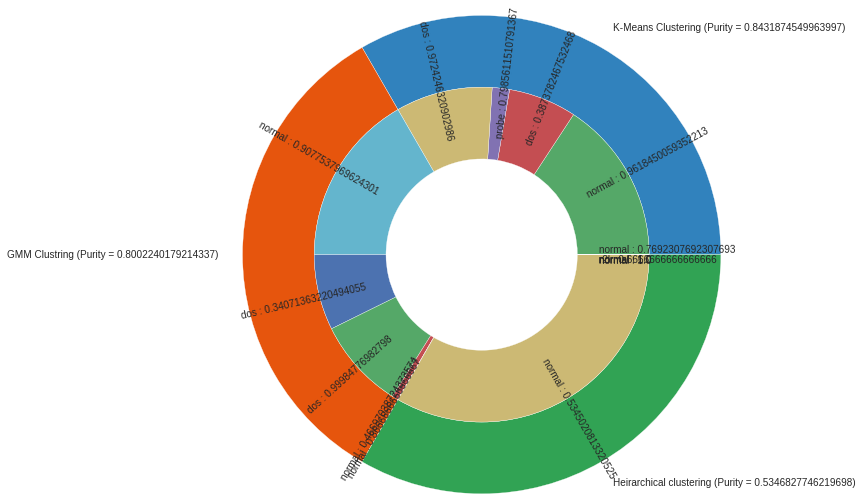

In [39]:
pieChart(noofneurons=[29,14,29],activationFunctions=[None,"relu","relu"],learningRat=0.1)

#### Deep autoencoders

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in exp


Pie chart comparing purity of KNN,GMM, and herirchical along with resp. clusters purity


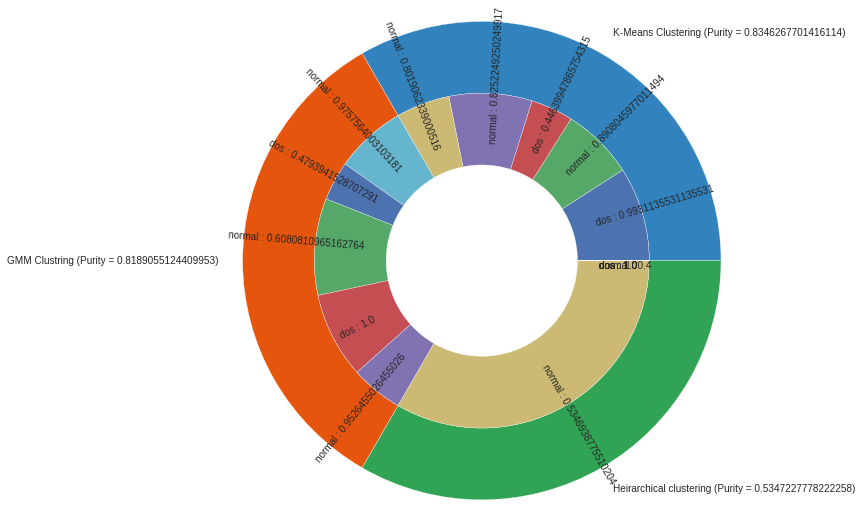

In [40]:
pieChart(noofneurons=[29,20,20,14,20,20,29],activationFunctions=[None,"sigmoid","sigmoid","sigmoid","sigmoid","sigmoid","sigmoid"],learningRat=2)

<hr>

## Question-2 Problem of Generating New Data.

In [72]:
digits = load_digits()
print(digits.data.shape)
data=digits.data

(1797, 64)


In [113]:
pca15 = PCA(n_components=15, whiten=False)
reducedData15 = pca15.fit_transform(data)
print(reducedData15.shape)

pca28 = PCA(n_components=28, whiten=False)
reducedData28 = pca28.fit_transform(data)
print(reducedData28.shape)

pca41 = PCA(n_components=41, whiten=False)
reducedData41 = pca41.fit_transform(data)
print(reducedData41.shape)

(1797, 15)
(1797, 28)
(1797, 41)


### Part-1:  Kernel Density Estimation:

In [0]:
def kde(reducedData):
  print("KDE for reduced data with dimension ",reducedData.shape[1])
  grid = GridSearchCV(KernelDensity(), {'bandwidth': np.logspace(-1, 1, 20)}, cv=5)
  grid.fit(reducedData)
  print("optimized bandwidth: ",grid.best_estimator_.bandwidth)
  # use the best estimator to compute the kernel density estimate
  kde = grid.best_estimator_

In [87]:
kde(reducedData15)
kde(reducedData28)
kde(reducedData41)

KDE for reduced data with dimension  15
optimized bandwidth:  3.79269019073225
KDE for reduced data with dimension  28
optimized bandwidth:  2.9763514416313175
KDE for reduced data with dimension  41
optimized bandwidth:  2.3357214690901213


### Part-2 : Gaussian Mixture Model based Density Estimation:

In [0]:
def gmmde(reducedData,pca):
  print("Gaussian Mixture Model based Density Estimation on dimension ",reducedData.shape[1])
  totalComponents = np.arange(1,40)
  mdls = [GaussianMixture(comp, covariance_type='full', random_state=0)for comp in totalComponents]
  bics = [model.fit(reducedData).bic(reducedData) for model in mdls]
  resultantComp=totalComponents[np.argmin(bics)]
  print("Smallest Bayesian Information Criteria for ",resultantComp, " Components")
  plt.plot(totalComponents, bics);
  plt.show()
  

  mdl = GaussianMixture(resultantComp, covariance_type='full', random_state=0)
  mdl.fit(reducedData)
#   print(gmm.converged_)
#   sampledData=mdl.sample(2)
#   print(len(sampleData[1]))
#   print(mdl.sample(5)[0].shape)
#   print(np.array(sampleData))
  
  transformedData = pca.inverse_transform(mdl.sample(5)[0])
  print(transformedData.shape)

Gaussian Mixture Model based Density Estimation on dimension  15
Smallest Bayesian Information Criteria for  10  Components


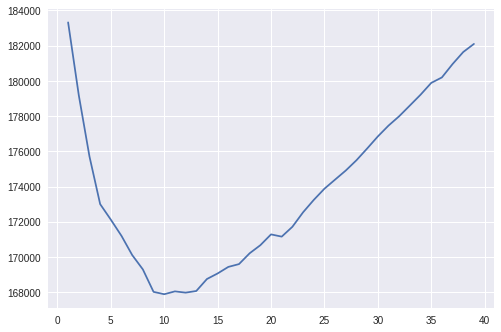

(5, 64)


In [130]:
gmmde(reducedData15,pca15)
# gmmde(reducedData28)
# gmmde(reducedData41)